# Visualization of Zillow Home Values via Matplotlib and Tableau:

Using Zillow data from Quandl and geographic zip code data provided by the city of Los Angeles, a map of Zillow home value percentile (for all homes) was created using Python's Matplotlib library, see Fig 1 below.

Plotting (or mapping) this data alongside the California coast line (via the geopandas dataset) shows a negative correlation between distance from coast and Zillow home value. This is particularly evident for zip codes located directly on the coast, all of which are in the top 20 percentile of Zillow home values. 

Of course, there are deviations from the simple correlation of home value and distance from coast. For example, areas including and surrounding Hollywood, the mecca of the film industry in the US (red star), have high Zillow home values despite their greater distance from the coast.

#### Map of Zip Code Home Value in Los Angeles, with the California coast line included:

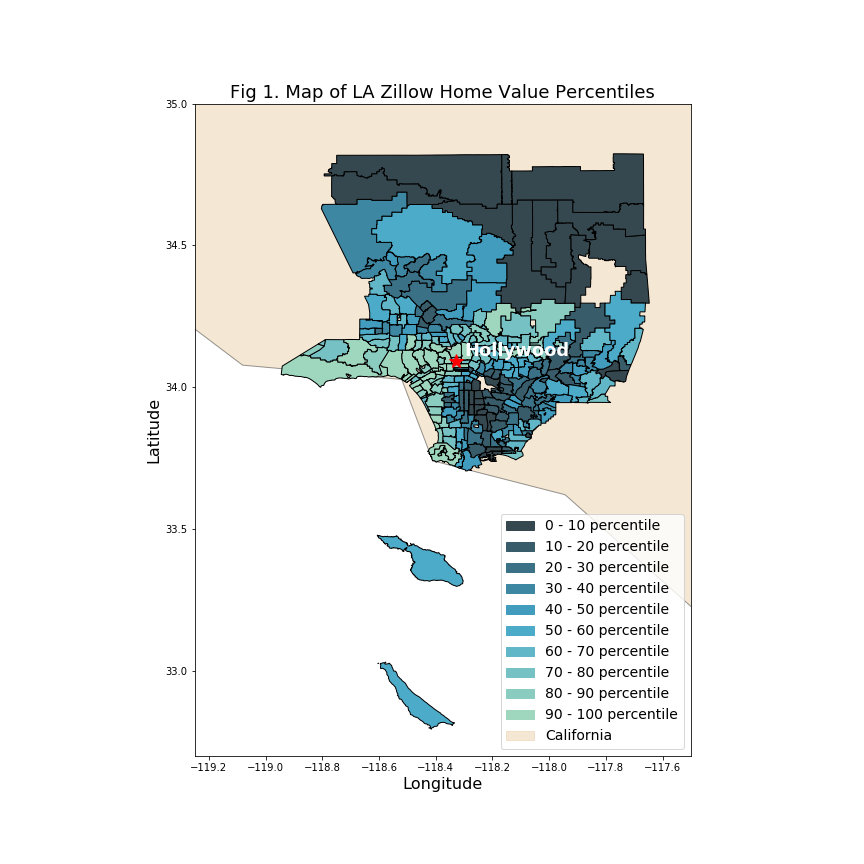

In [67]:
from IPython.display import Image
Image('Zillow_Home_Value_Coast.png')

### A similar version of this map was created in Tableau. 
The map is presented as part of an embedded Tableau dashboard below.

This dashboard includes an additional plot of Zillow home price as a function of time for each zip code. 

The dashboard is interactive: Clicking on a zip code in the top map highlights the time series trace of that zip code in the bottom figure. 

My Tableau Public Profile: https://public.tableau.com/profile/jen.peper#!/

In [69]:
%%HTML
<div class='tableauPlaceholder' id='viz1576794135111' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;LA&#47;LAMapandHomeValueTimeSeries&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='LAMapandHomeValueTimeSeries&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;LA&#47;LAMapandHomeValueTimeSeries&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1576794135111');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

# Import required libraries:

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches   

import geopandas
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch

import pickle
import re
import datetime
import quandl

In [7]:
with open("Personal_Quandl_Key.txt", "r") as f:
    quandl_key = f.readline()

quandl.ApiConfig.api_key = quandl_key

#quandl.ApiConfig.api_key = "Insert your Quandl key here."

In [4]:
# SHORT CUT: Import dataframe for this notebook: 
   
# Zillow data with zipcode GeoDataFrame:    
with open('zillow_zip_gdf.p', 'rb') as f:
    zillow_zip_gdf = pickle.load(f)

# Import LA Zip Code and Zillow Data:

### LA ZIP CODE:
Data and data description available at the following link: https://data.lacounty.gov/Geospatial/ZIP-Codes/65v5-jw9f

In [5]:
LA_Zip_Codes = r"C:\Users\J Peper\Peper_Fun\P1_Arrest_and_Community_Space\laZips.geojson.txt"
la_zip_gdf = geopandas.GeoDataFrame.from_file(LA_Zip_Codes)

### ZILLOW DATA:
Zillow Home Value Index data (updated mounthly) is freely avalable via the Quandl API.

Quandl Zillow data description: https://www.quandl.com/data/ZILLOW-Zillow-Real-Estate-Research/documentation

**Quandl Code Format:** ZILLOW/{AREA_CATEGORY}{AREA_CODE}_{INDICATOR_CODE}


Import the **Zillow Home Value Index (for all homes)** from Quandl for each LA Zip Code from 2008-2018:

In [51]:
from quandl.errors.quandl_error import NotFoundError

Zillow_df = pd.DataFrame(columns=["Value", "zipcode"])
La_Zip_Codes = la_zip_gdf.zipcode.tolist()  # Create a list of LA Zip Codes

for ZipCode in La_Zip_Codes:
    quandl_code = "ZILLOW/Z"+ZipCode+"_ZHVIAH"
    try:
        temp_df = quandl.get(quandl_code, start_date='2008-01-01', end_date ='2019-01-01')
    except (SyntaxError, NotFoundError):
        continue
    else:
        temp_df["zipcode"] = ZipCode
        Zillow_df = Zillow_df.append(temp_df)

In [53]:
Zillow_df = Zillow_df.reset_index().copy()
Zillow_df.columns = ["Date", "Value", "zipcode"]

In [58]:
#with open('Zillow_df.p', 'wb') as f:
#    pickle.dump(Zillow_df, f)
    
# Zillow data from 2008-2018:   
with open('Zillow_df.p', 'rb') as f:
    Zillow_df = pickle.load(f)  

#### Create CSV file containing all Zillow data (2008-2018) for use in Tableau:

In [59]:
Zillow_08_18_csv = Zillow_df.copy()
Zillow_08_18_csv.columns = ["Date", "Home_Value", "Postal Code"]

Zillow_08_18_csv.to_csv("Zillow_08_18.csv")

#### Select data from Jan 2018 for analysis in Matplotlib:

In [39]:
jan_01_2018 = pd.Timestamp(2018, 1, 1, 0) 
feb_01_2018 = pd.Timestamp(2018, 2, 1, 0)  

Zillow_2018_df = Zillow_df[(Zillow_df.Date > jan_01_2018) &(Zillow_df.Date < feb_01_2018)].copy()

#### Merger Zillow and LA Zip Code Dataframes (zillow_zip_gdf):

In [ ]:
zillow_zip_gdf = la_zip_gdf.merge(Zillow_2018_df, on = "zipcode", how = "inner")

Save the zillow_zip_gdf as a pickle file for easy access later:

In [34]:
#with open('zillow_zip_gdf.p', 'wb') as f:
#    pickle.dump(zillow_zip_gdf, f)
    
    
# Zillow data with zipcode GeoDataFrame:    
with open('zillow_zip_gdf.p', 'rb') as f:
    zillow_zip_gdf = pickle.load(f)

In [3]:
zillow_zip_gdf.head(1)

,objectid,shape_area,shape_len,zipcode,geometry,Value
0,1,95563401.532,48677.2784778,90001,(POLYGON ((-118.2433683530738 33.9892312651088...,352100.0


# Data Visualization with Matplotlib:

In [64]:
# Generate a dictionary of percentiles (keys) and color hex codes (values):
percentiles = np.round(np.arange(0, 1.0, 0.1), 1).tolist()

num_shades = len(percentiles)

color_palette = sns.color_palette("GnBu_d", num_shades).as_hex()
color_dictionary = dict(zip(percentiles, color_palette))



# Calculate the percentile of the home value for each zip code:
zillow_zip_gdf['Percentile'] = zillow_zip_gdf["Value"].rank(pct=True)
zillow_zip_gdf['RoundDown_Percentile'] = np.round(0.1*(np.floor(zillow_zip_gdf['Percentile']*10)), 1)



# Assign color based on home values percentile:
def Color_Assignment(RoundDown_Percentile):
    if RoundDown_Percentile == 1:
        return color_dictionary[0.9]
    else:
        return color_dictionary[RoundDown_Percentile]

zillow_zip_gdf["Color"] = zillow_zip_gdf[["RoundDown_Percentile"]].applymap(lambda value: Color_Assignment(value))
zillow_zip_gdf.head(1)

,objectid,shape_area,shape_len,zipcode,geometry,Value,Percentile,RoundDown_Percentile,Color
0,1,95563401.532,48677.2784778,90001,(POLYGON ((-118.2433683530738 33.9892312651088...,352100.0,0.05,0.0,#36484f


#### Plot 1: Map of Zillow Home Value in Los Angeles

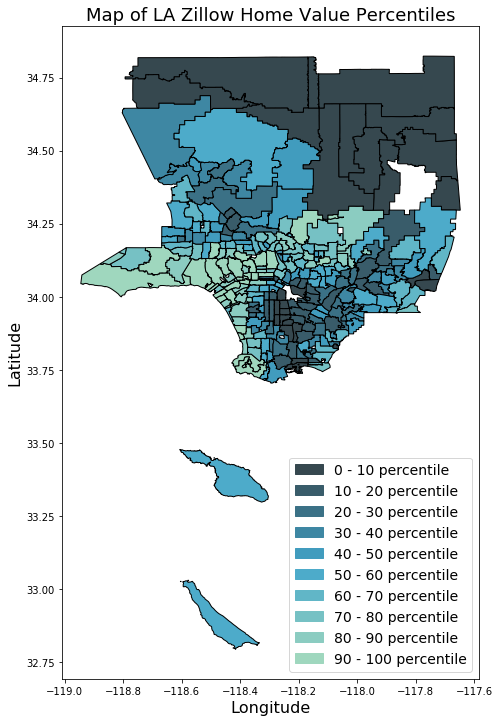

In [65]:
# Make plot of Zip Code and Zillow home price percentile:
fig, ax = plt.subplots(figsize=(12,12)) 

for i, row in zillow_zip_gdf.iterrows():
    color_code = row.Color
    ax.add_patch(PolygonPatch(row.geometry, fc=color_code, ec = "black", alpha=1.0, zorder=2))
ax.set_title("Map of LA Zillow Home Value Percentiles", loc = "center", fontsize = 18)
ax.set_xlabel("Longitude", fontsize = 16)
ax.set_ylabel("Latitude", fontsize = 16)
ax.axis('scaled')
    
    
# Generate custom legend
patched_dict = {}
for percentile in color_dictionary.keys():
    color = color_dictionary[percentile]
    lower = round(percentile*100)
    upper = round((percentile+.1)*100)
    label = str(lower)+ " - "+str(upper)+ " percentile"
    temp_patch = mpatches.Patch(color = color, label = label)
    patched_dict[percentile] = temp_patch
custom_legend= list(patched_dict.values())  
plt.legend(handles=custom_legend, loc = 4, fontsize = 14)

fig.savefig('Zillow_Home_Value.png')

#### Plot 2: Map of Home Value for each zip code in Los Angeles, with the California coast line included

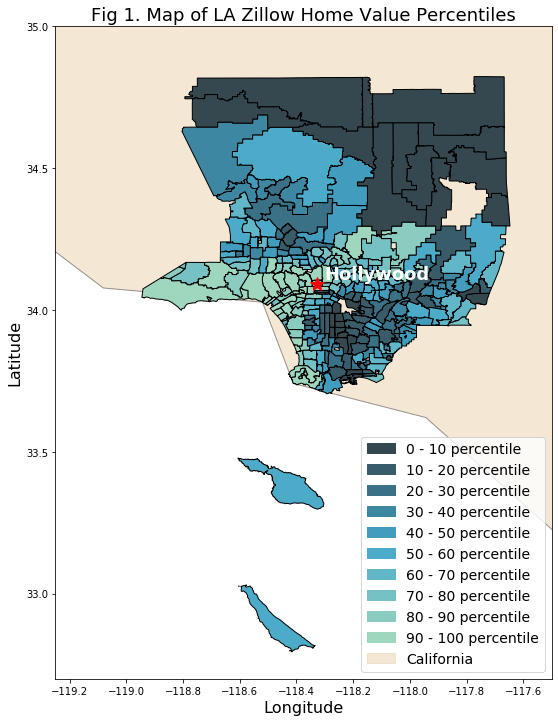

In [66]:
fig, ax = plt.subplots(figsize=(12,12)) 

# Add plot of california coast via the geopandas database.
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world[world.name == 'United States'].plot(ax = ax, color='#e5c494', edgecolor='black', alpha = 0.4)

# Add Zip Code
for i, row in zillow_zip_gdf.iterrows():
    color_code = row.Color
    ax.add_patch(PolygonPatch(row.geometry, fc=color_code, ec = "black", alpha=1.0, zorder=2))

    
hollywood = ax.plot([-118.3287], [34.0928], marker = '*', markersize = 15, color="red", zorder=3, label = "Hollywood")
ax.text(-118.3, 34.11, "Hollywood", color = "White", fontsize = 18, weight = "bold")

# Set Title and Axis Labels
ax.set_title("Fig 1. Map of LA Zillow Home Value Percentiles", loc = "center", fontsize = 18)
ax.set_xlabel("Longitude", fontsize = 16)
ax.set_ylabel("Latitude", fontsize = 16)
ax.axis('scaled')
xmin = -119.25
xmax = -117.5
ymin = 32.7
ymax = 35
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))


 
# Generate custom legend
patched_dict = {}
for percentile in color_dictionary.keys():
    color = color_dictionary[percentile]
    lower = round(percentile*100)
    upper = round((percentile+.1)*100)
    label = str(lower)+ " - "+str(upper)+ " percentile"
    temp_patch = mpatches.Patch(color = color, label = label)
    patched_dict[percentile] = temp_patch   
patched_dict["California"] = temp_patch = mpatches.Patch(color = '#e5c494', alpha = 0.4, label = "California")
custom_legend= list(patched_dict.values())

plt.legend(handles=custom_legend, loc = 4, fontsize = 14)
fig.savefig('Zillow_Home_Value_Coast.png')